In [189]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import pickle

In [3]:
df = pd.read_csv('data/zillow_data.csv')
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [67]:
zipcode_converter = dict(zip(list(df[df['State']=='NV']['RegionID']),list(df[df['State']=='NV']['RegionName'])))

In [4]:
df_time_series = pd.DataFrame(index=pd.to_datetime(df.columns[7:]), data=np.ones(len(df.columns)-7))
for i in range(df.shape[0]):
    df_time_series[df['RegionID'][i]] = df.iloc[i,7:]
df_time_series.drop(df_time_series.columns[0],axis=1, inplace=True)
df_time_series

,84654,90668,91982,84616,93144,91733,61807,84640,91940,97564,...,59187,94711,62556,99032,62697,58333,59107,75672,93733,95851
1996-04-01,334200,235700,210400,498100,77300,95000,152900,216500,95400,766000,...,80800,135900,78300,136200,62500,94600,92700,57100,191100,176400
1996-05-01,335400,236900,212200,500900,77300,95200,152700,216700,95600,771100,...,80100,136300,78300,136600,62600,94300,92500,57300,192400,176300
1996-06-01,336500,236700,212200,503100,77300,95400,152600,216900,95800,776500,...,79400,136600,78200,136800,62700,94000,92400,57500,193700,176100
1996-07-01,337600,235400,210700,504600,77300,95700,152400,217000,96100,781900,...,78600,136900,78200,136800,62700,93700,92200,57700,195000,176000
1996-08-01,338500,233300,208300,505500,77400,95900,152300,217100,96400,787300,...,77900,137100,78100,136700,62700,93400,92100,58000,196300,175900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,1018700,316600,321200,1299000,120300,162800,414300,777900,172300,3778700,...,123400,257600,171300,341000,122800,216400,213100,130600,694700,348900
2018-01-01,1024400,318100,321200,1302700,120300,162800,413900,778500,173300,3770800,...,124400,258000,172400,342300,123200,213100,213700,131700,706400,350400
2018-02-01,1030700,319600,323000,1306400,120500,162900,411400,780500,174200,3763100,...,125500,260600,173600,345000,123200,209800,218300,132500,705300,353000
2018-03-01,1033800,321100,326900,1308500,121000,163500,413200,782800,175400,3779800,...,126600,264700,175800,348000,120700,209200,222700,133000,681500,356000


In [5]:
df_time_series.isna().sum().sum()

156891

In [6]:
df_nv = df[df['State'] == 'NV']
nv_zipcodes = list(df_nv.RegionID)
nv_zipcodes[0]

95804

In [7]:
df_time_series.fillna(method='bfill', inplace=True)

In [8]:
df_time_series.isna().sum().sum()

0

We can see that these zipcodes have different characteristics

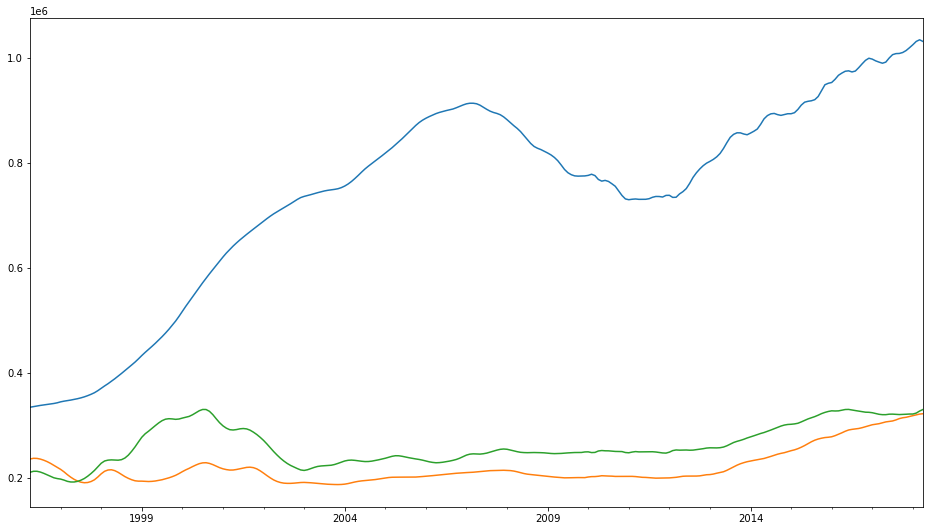

In [9]:
df_time_series.iloc[:,0].plot(figsize=(16,9))
df_time_series.iloc[:,1].plot()
df_time_series.iloc[:,2].plot();

# RNN Model

In [10]:
size = int(len(df_time_series)*.8)
train = df_time_series.iloc[:size]
test = df_time_series.iloc[size:]

In [11]:
df_time_series = df_time_series[nv_zipcodes]
train = train[nv_zipcodes]
test = test[nv_zipcodes]

We are trying a RNN model to see how it does on our first zipcode

In [12]:
x = 0
train_data = train.iloc[:,x:x+1].values.astype(int)
test_data = test.iloc[:,x:x+1].values.astype(int)

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.fit_transform(test_data)

In [263]:
train_data_scaled

array([[2.16841344e-03],
       [1.80701120e-03],
       [1.08420672e-03],
       [7.22804481e-04],
       [3.61402241e-04],
       [0.00000000e+00],
       [0.00000000e+00],
       [7.22804481e-04],
       [1.44560896e-03],
       [2.52981568e-03],
       [3.25262017e-03],
       [3.61402241e-03],
       [3.61402241e-03],
       [3.97542465e-03],
       [4.33682689e-03],
       [4.69822913e-03],
       [5.05963137e-03],
       [5.78243585e-03],
       [6.50524033e-03],
       [7.58944705e-03],
       [9.03505602e-03],
       [1.12034695e-02],
       [1.22876762e-02],
       [1.30104807e-02],
       [1.37332851e-02],
       [1.40946874e-02],
       [1.48174919e-02],
       [1.55402963e-02],
       [1.62631008e-02],
       [1.73473076e-02],
       [1.84315143e-02],
       [1.98771232e-02],
       [2.20455367e-02],
       [2.42139501e-02],
       [2.56595591e-02],
       [2.67437658e-02],
       [2.78279725e-02],
       [2.92735815e-02],
       [3.07191905e-02],
       [3.21647994e-02],


Creating a dataset with 60 timesteps (5 years)

In [14]:
X_train = []
y_train = []
for i in range(60,len(train_data_scaled)):
    X_train.append(train_data_scaled[i-60:i])
    y_train.append(train_data_scaled[i])

data_total = pd.concat((train.iloc[:,x:x+1], test.iloc[:,x:x+1]),axis=0)
inputs = data_total[len(train)-60:].values
inputs = scaler.transform(inputs)

X_test = []
y_test = []
for i in range(60,len(inputs)):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i])
X_test = np.array(X_test)
y_test = np.array(test_data)

Turn data into arrays for RNN

In [15]:
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

In [16]:
rnn_model = Sequential()
rnn_model.add(LSTM(units= 60, return_sequences = False, input_shape=((60,1))))
rnn_model.add(Dense(units=1))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60)                14880     
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


In [17]:
rnn_model.fit(X_train, y_train, epochs=100, batch_size=32)


Epoch 1/100
5/5 [==============================] - 0s 18ms/step - loss: 0.1800
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 0.0610
Epoch 3/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0283
Epoch 4/100
5/5 [==============================] - 0s 15ms/step - loss: 0.0209
Epoch 5/100
5/5 [==============================] - 0s 13ms/step - loss: 0.0129
Epoch 6/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0138
Epoch 7/100
5/5 [==============================] - 0s 19ms/step - loss: 0.0104
Epoch 8/100
5/5 [==============================] - 0s 19ms/step - loss: 0.0085
Epoch 9/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0070
Epoch 10/100
5/5 [==============================] - 0s 13ms/step - loss: 0.0054
Epoch 11/100
5/5 [==============================] - 0s 15ms/step - loss: 0.0042
Epoch 12/100
5/5 [==============================] - 0s 13ms/step - loss: 0.0028
Epoch 13/100
5/5 [==============================]

In [18]:
y_hat_raw = rnn_model.predict(X_test)
y_hat = scaler.inverse_transform(y_hat_raw)

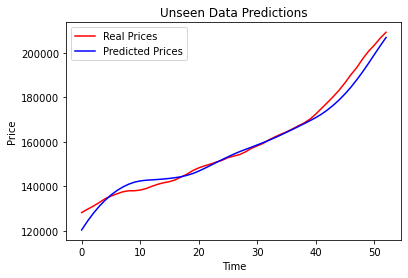

In [19]:
plt.plot(y_test, color='red', label='Real Prices')
plt.plot(y_hat, color='blue', label='Predicted Prices')
plt.title('Unseen Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;

Although our model was successful on the first zipcode, when we check its success on other zipcodes we see that the results are not always good.

In [22]:
print_in = open('jupyter_files/rnn_mape.pickle','rb')
rnn_mape = pickle.load(print_in)
print_in.close()

On average our first RNN model has MAPE value of 20%. We can use this model for some zipcodes but not all of them.

In [24]:
np.mean(rnn_mape)

0.201744244348875

In [25]:
print_in = open('jupyter_files/rnn_mape2.pickle','rb')
rnn_mape2 = pickle.load(print_in)
print_in.close()
print_in = open('jupyter_files/rnn_mape3.pickle','rb')
rnn_mape3 = pickle.load(print_in)
print_in.close()
print_in = open('jupyter_files/rnn_mape4.pickle','rb')
rnn_mape4 = pickle.load(print_in)
print_in.close()

In [73]:
print_in = open('jupyter_files/rnn_dict.pickle','rb')
rnn_dict = pickle.load(print_in)
print_in.close()
print_in = open('jupyter_files/rnn_dict2.pickle','rb')
rnn_dict2 = pickle.load(print_in)
print_in.close()
print_in = open('jupyter_files/rnn_dict3.pickle','rb')
rnn_dict3 = pickle.load(print_in)
print_in.close()
print_in = open('jupyter_files/rnn_dict4.pickle','rb')
rnn_dict4 = pickle.load(print_in)
print_in.close()

In [26]:
np.mean(rnn_mape2), np.mean(rnn_mape3), np.mean(rnn_mape4)

(0.2113528638887323, 0.20615423245296247, 0.2119248143820323)

In [127]:
rnn_dict_keys = []
for key in rnn_dict.keys():
    rnn_dict_keys.append(zipcode_converter[key])
rnn_model_dict = dict(zip(rnn_dict_keys, rnn_dict.values()))
rnn_dict_keys2 = []
for key in rnn_dict2.keys():
    rnn_dict_keys2.append(zipcode_converter[key])
rnn_model_dict2 = dict(zip(rnn_dict_keys2, rnn_dict2.values()))
rnn_dict_keys3 = []
for key in rnn_dict3.keys():
    rnn_dict_keys3.append(zipcode_converter[key])
rnn_model_dict3 = dict(zip(rnn_dict_keys3, rnn_dict3.values()))
rnn_dict_keys4 = []
for key in rnn_dict4.keys():
    rnn_dict_keys4.append(zipcode_converter[key])
rnn_model_dict4 = dict(zip(rnn_dict_keys4, rnn_dict4.values()))

# Facebook Prophet Model

The model below iterates over every zipcode in Nevada and predecits the prices in May 2018. It cross validates the model fitted with 17 years of training data, one year of validation set (horizon) and the model makes predictions per zipcode for each year between 2013 and 2017. It returns average Mean Absolute Percentage Error (MAPE) for each zipcode.

In [30]:
print_in = open('jupyter_files/fbp_mape2.pickle','rb')
fbp_mape2_ = pickle.load(print_in)
print_in.close()
print_in = open('jupyter_files/fbp_mape.pickle','rb')
fbp_mape_ = pickle.load(print_in)
print_in.close()
print_in = open('jupyter_files/fbp_pred2.pickle','rb')
fbp_pred2_ = pickle.load(print_in)
print_in.close()
print_in = open('jupyter_files/fbp_pred.pickle','rb')
fbp_pred_ = pickle.load(print_in)
print_in.close()

In [72]:
fbp_keys = list(fbp_mape_.keys())
fbp_mape = list(fbp_mape_.values())
fbp_pred = []
fbp_dict = {}
for zipcode in fbp_pred_.keys():
    fbp_pred.append(fbp_pred_[zipcode].astype(int))
for zc in fbp_keys:
    a = []
    a.append(fbp_mape_[zc])
    a.append(fbp_pred_[zc].astype(float))
    a.append('FBP_scale=0.5')
    fbp_dict[zipcode_converter[zc]] = a

In [68]:
fbp_keys2 = list(fbp_mape2_.keys())
fbp_mape2 = list(fbp_mape2_.values())
fbp_pred2 = []
fbp_dict2 = {}
for zipcode2 in fbp_pred2_.keys():
    fbp_pred2.append(fbp_pred2_[zipcode].astype(int))
for zc in fbp_keys2:
    a = []
    a.append(fbp_mape2_[zc])
    a.append(fbp_pred2_[zc].astype(float))
    a.append('FBP_scale=0.25')
    fbp_dict2[zipcode_converter[zc]] = a

In [69]:
fbp_dict2

{89005: [0.06201812204786679, 306424.2937773095, 'FBP_scale=0.25'],
 89011: [0.07365250988633827, 261756.02208454325, 'FBP_scale=0.25'],
 89012: [0.05968572468179214, 339800.2000154268, 'FBP_scale=0.25'],
 89014: [0.04821833597534795, 285310.6731272519, 'FBP_scale=0.25'],
 89015: [0.06071354411346397, 249675.968724543, 'FBP_scale=0.25'],
 89021: [0.055411917518816696, 314914.61125532206, 'FBP_scale=0.25'],
 89027: [0.03519882691258607, 232696.08040677305, 'FBP_scale=0.25'],
 89029: [0.051091422023326595, 182731.03140031238, 'FBP_scale=0.25'],
 89030: [0.06394259446634014, 149729.67426600133, 'FBP_scale=0.25'],
 89031: [0.07358537937188435, 239500.18036715218, 'FBP_scale=0.25'],
 89032: [0.08398816189546444, 224538.93967787863, 'FBP_scale=0.25'],
 89040: [0.05651007004529196, 202263.96185782555, 'FBP_scale=0.25'],
 89044: [0.05480307208535111, 346865.3214184451, 'FBP_scale=0.25'],
 89048: [0.07346922582325782, 192268.57160478728, 'FBP_scale=0.25'],
 89052: [0.05160073139390173, 408455.1

In [39]:
np.mean(fbp_mape), np.mean(fbp_mape2)

(0.037575237987934114, 0.056519773001086626)

# SARIMA - SARIMAX

In [42]:
print_in = open('jupyter_files/SARIMAX_summary.pickl','rb')
sarimax_dict = pickle.load(print_in)
print_in.close()
print_in = open('jupyter_files/SARIMA_summary.pickl','rb')
sarima_dict = pickle.load(print_in)
print_in.close()

In [54]:
list(sarima_dict.values())[0][1]

0.14147840001613393

In [91]:
sarima_model_dict = {}
for z in range(len(sarima_dict.keys())):
    a = []
    a.append(list(sarima_dict.values())[z][1])
    a.append(list(sarima_dict.values())[z][0])
    a.append(list(sarima_dict.values())[z][2])
    sarima_model_dict[list(sarima_dict.keys())[z]] = a

sarimax_model_dict = {}
for z in range(len(sarimax_dict.keys())):
    a = []
    a.append(list(sarimax_dict.values())[z][1])
    a.append(list(sarimax_dict.values())[z][0])
    a.append(list(sarimax_dict.values())[z][2])
    sarimax_model_dict[list(sarimax_dict.keys())[z]] = a


In [106]:
sarima_mape_list = []
for z in range(len(sarima_dict.keys())):
    sarima_mape_list.append(list(sarima_dict.values())[z][1])

sarimax_mape_list = []
for z in range(len(sarimax_dict.keys())):
    sarimax_mape_list.append(list(sarimax_dict.values())[z][1])


### Best Model

In [128]:
models = [rnn_model_dict, rnn_model_dict2, rnn_model_dict3, rnn_model_dict4, fbp_dict, fbp_dict2, sarima_model_dict, sarimax_model_dict]
best_model_dict = {}
for zipcode in sarima_model_dict.keys():
    best_model = [1,1]
    for model in models:
        if model[zipcode][0]<best_model[0]:
            best_model = model[zipcode]
    best_model_dict[zipcode] = best_model

In [130]:
best_model_dict

{89102: [0.040796909553926605, 220765.39635029866, 'FBP_scale=0.5'],
 89103: [0.013505008741549612, 251018.2237947004, 'Sarimax'],
 89104: [0.03320603155912621, 212632.1144190938, 'FBP_scale=0.5'],
 89107: [0.05935506051263894, 198917.1941191062, 'FBP_scale=0.5'],
 89108: [0.053552150532358844, 212876.99612153973, 'FBP_scale=0.5'],
 89109: [0.06120353804433491, 310200.0, 'Sarimax'],
 89110: [0.04725188507969076, 200482.01372467002, 'FBP_scale=0.5'],
 89113: [0.008562374309784411, 308646.96875, 'RNN_2_Layers'],
 89115: [0.047750494294313994, 177213.75103653304, 'SARIMA'],
 89117: [0.010808055744779672, 343835.59375, 'RNN_2_Layers'],
 89118: [0.030271458421119, 271179.49889021384, 'FBP_scale=0.5'],
 89119: [0.026782273794856256, 241955.26361875163, 'FBP_scale=0.5'],
 89120: [0.04554779842216769, 267252.62681162066, 'FBP_scale=0.5'],
 89121: [0.03251929889460807, 212357.25585671476, 'FBP_scale=0.5'],
 89122: [0.014471367203184187, 207761.12401967685, 'Sarimax'],
 89123: [0.011060594461016

In [246]:
model_types = []
for item in best_model_dict.values():
    model_types.append([item[2]])
list = []
for item in model_types:
    list.append(item[0])
labels = set(list)
sizes = []
#list.count(labels[0])
for i in labels:
    sizes.append(list.count(i))
labels, sizes
labels2 = x = ['FB Prophet 50% Scaler', 'SARIMA','RNN w/ Dropout', 'SARIMAX','RNN 2 Layers','RNN 2 Layers w/ Dropout','RNN']
labels, sizes

({'FBP_scale=0.5',
  'RNN',
  'RNN_2_Layers',
  'RNN_2_layer_w/_D.o.',
  'RNN_w/_D.o.',
  'SARIMA',
  'Sarimax'},
 [27, 14, 12, 14, 12, 1, 18])

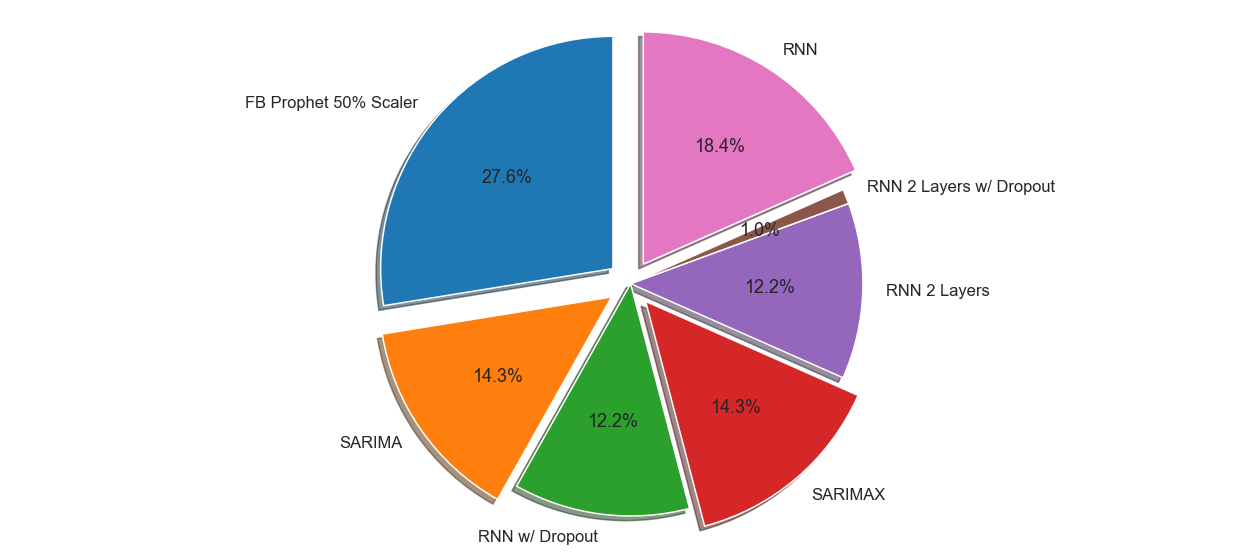

In [247]:
explode = (0.1, 0.1, 0, 0.1, 0, 0, 0.1) 

fig1, ax1 = plt.subplots(figsize=(22,10))
ax1.pie(sizes, explode=explode, labels=labels2, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.xticks(fontsize= 50)
plt.show()
fig1.savefig('pie.png')

### Model Comparision

In [156]:
best_model_mape_list = []
for item in best_model_dict.values():
    best_model_mape_list.append(item[0])

In [157]:
rnn_1_mape = np.mean(rnn_mape)
rnn_2_mape = np.mean(rnn_mape2)
rnn_3_mape = np.mean(rnn_mape3)
rnn_4_mape = np.mean(rnn_mape4)
fbp_1_mape = np.mean(fbp_mape)
fbp_2_mape = np.mean(fbp_mape2)
sarima_mape = np.mean(sarima_mape_list)
sarimax_mape = np.mean(sarimax_mape_list)
best_model_mape = np.mean(best_model_mape_list)

<ipython-input-223-de4837f53625>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0%','2.5%','5%','7.5%','10%','12.5%','15%','17.5%','20%'])
<ipython-input-223-de4837f53625>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = x, rotation=40)


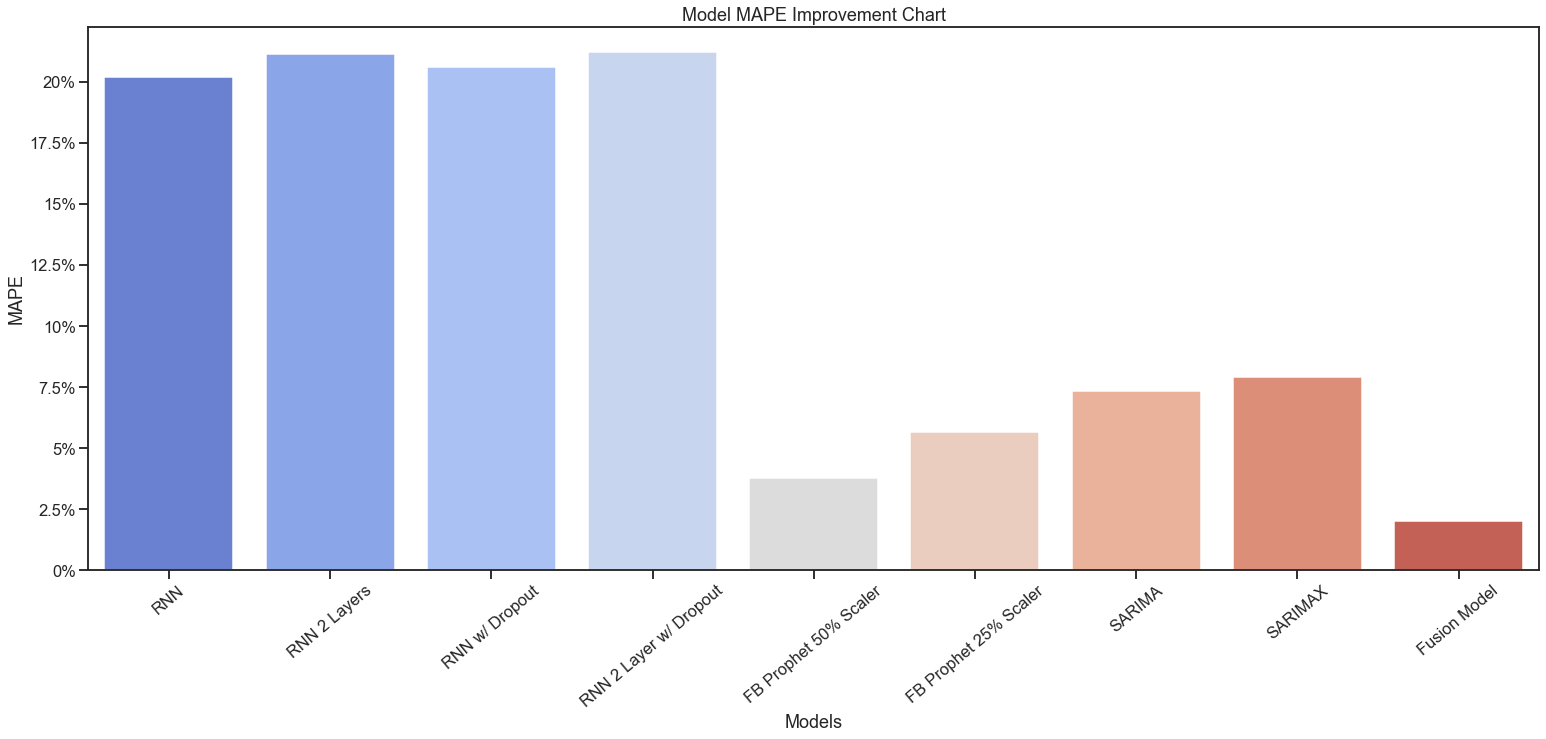

In [223]:
fig, ax = plt.subplots(figsize=(26,10))


y = [rnn_1_mape,rnn_2_mape,rnn_3_mape,rnn_4_mape, fbp_1_mape, fbp_2_mape, sarima_mape, sarimax_mape, best_model_mape]
x = ['RNN','RNN 2 Layers','RNN w/ Dropout','RNN 2 Layer w/ Dropout', 'FB Prophet 50% Scaler', 'FB Prophet 25% Scaler', 'SARIMA', 'SARIMAX', 'Fusion Model']
ax.set_title('Model MAPE Improvement Chart')
ax.set_yticklabels(['0%','2.5%','5%','7.5%','10%','12.5%','15%','17.5%','20%'])
ax.set_xticklabels(labels = x, rotation=40)
ax.set_ylabel('MAPE')
ax.set_xlabel('Models')
sns.barplot(x=x, y=y, palette="coolwarm")
sns.set_style('ticks')
sns.set_context("talk");
fig.savefig('model_improvement.png')

Adding our Best Models predictions to our DataFrame

In [170]:
zipcode_columns = []
for column in df_time_series.columns:
    zipcode_columns.append(zipcode_converter[column])

In [172]:
df_time_series.columns = zipcode_columns

In [173]:
df_time_series

,89108,89121,89117,89052,89123,89031,89110,89074,89103,89148,...,89444,89085,89034,89021,89439,89411,89124,89440,89413,89155
1996-04-01,102500.0,106800.0,165100.0,185700.0,144000.0,122800.0,95800.0,148000.0,118900.0,157300.0,...,116800.0,170900.0,196000.0,153200.0,184200.0,299200.0,166100.0,293200.0,562400.0,176400.0
1996-05-01,102500.0,107000.0,164500.0,186300.0,143500.0,122800.0,95800.0,147800.0,119000.0,156000.0,...,117000.0,170800.0,196000.0,153700.0,185000.0,299600.0,166600.0,293200.0,562800.0,176300.0
1996-06-01,102500.0,107200.0,164000.0,186900.0,143100.0,122700.0,95800.0,147600.0,119000.0,154700.0,...,117200.0,170700.0,195900.0,154100.0,185800.0,299900.0,167300.0,293200.0,562700.0,176100.0
1996-07-01,102600.0,107400.0,163500.0,187400.0,142700.0,122700.0,95900.0,147300.0,119100.0,153500.0,...,117400.0,170700.0,195700.0,154400.0,186400.0,300200.0,167900.0,293200.0,562400.0,176000.0
1996-08-01,102700.0,107600.0,163200.0,187700.0,142400.0,122700.0,96100.0,147100.0,119200.0,152600.0,...,117600.0,170700.0,195400.0,154700.0,186900.0,300500.0,168600.0,293200.0,562300.0,175900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,197300.0,198700.0,327100.0,403800.0,290400.0,231600.0,186600.0,300100.0,240400.0,291400.0,...,266200.0,313100.0,311700.0,298300.0,444500.0,639300.0,316800.0,199800.0,2098400.0,348900.0
2018-01-01,200700.0,201500.0,330700.0,407300.0,294300.0,234600.0,189200.0,303500.0,243700.0,294100.0,...,270000.0,316500.0,315500.0,299900.0,449500.0,642500.0,317600.0,201600.0,2121300.0,350400.0
2018-02-01,203500.0,204000.0,334600.0,410400.0,297400.0,237200.0,191700.0,306700.0,246300.0,296900.0,...,275600.0,319500.0,319500.0,302500.0,450100.0,653800.0,323400.0,207000.0,2153600.0,353000.0
2018-03-01,206600.0,206700.0,338800.0,413700.0,300200.0,239800.0,194500.0,309800.0,249500.0,299400.0,...,282100.0,322400.0,323600.0,305700.0,451100.0,666000.0,334700.0,216500.0,2167100.0,356000.0


In [175]:
predictions_05_18 = []
for zipcode in df_time_series.columns:
    if zipcode in best_model_dict.keys():
        predictions_05_18.append(best_model_dict[zipcode][1])
    else:
        predictions_05_18.append(0)

In [177]:
len(predictions_05_18)

103

In [178]:
df_time_series.loc['2018-05-01_pred'] = predictions_05_18


/Users/ferityikar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [179]:
df_time_series

,89108,89121,89117,89052,89123,89031,89110,89074,89103,89148,...,89444,89085,89034,89021,89439,89411,89124,89440,89413,89155
1996-04-01 00:00:00,102500.000000,106800.000000,165100.00000,185700.000,144000.00000,122800.000000,95800.000000,148000.00,118900.000000,157300.0000,...,116800.0000,170900.0,196000.0,153200.0,184200.00000,299200.0,166100.0000,293200.0,562400.000,176400.00000
1996-05-01 00:00:00,102500.000000,107000.000000,164500.00000,186300.000,143500.00000,122800.000000,95800.000000,147800.00,119000.000000,156000.0000,...,117000.0000,170800.0,196000.0,153700.0,185000.00000,299600.0,166600.0000,293200.0,562800.000,176300.00000
1996-06-01 00:00:00,102500.000000,107200.000000,164000.00000,186900.000,143100.00000,122700.000000,95800.000000,147600.00,119000.000000,154700.0000,...,117200.0000,170700.0,195900.0,154100.0,185800.00000,299900.0,167300.0000,293200.0,562700.000,176100.00000
1996-07-01 00:00:00,102600.000000,107400.000000,163500.00000,187400.000,142700.00000,122700.000000,95900.000000,147300.00,119100.000000,153500.0000,...,117400.0000,170700.0,195700.0,154400.0,186400.00000,300200.0,167900.0000,293200.0,562400.000,176000.00000
1996-08-01 00:00:00,102700.000000,107600.000000,163200.00000,187700.000,142400.00000,122700.000000,96100.000000,147100.00,119200.000000,152600.0000,...,117600.0000,170700.0,195400.0,154700.0,186900.00000,300500.0,168600.0000,293200.0,562300.000,175900.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 00:00:00,200700.000000,201500.000000,330700.00000,407300.000,294300.00000,234600.000000,189200.000000,303500.00,243700.000000,294100.0000,...,270000.0000,316500.0,315500.0,299900.0,449500.00000,642500.0,317600.0000,201600.0,2121300.000,350400.00000
2018-02-01 00:00:00,203500.000000,204000.000000,334600.00000,410400.000,297400.00000,237200.000000,191700.000000,306700.00,246300.000000,296900.0000,...,275600.0000,319500.0,319500.0,302500.0,450100.00000,653800.0,323400.0000,207000.0,2153600.000,353000.00000
2018-03-01 00:00:00,206600.000000,206700.000000,338800.00000,413700.000,300200.00000,239800.000000,194500.000000,309800.00,249500.000000,299400.0000,...,282100.0000,322400.0,323600.0,305700.0,451100.00000,666000.0,334700.0000,216500.0,2167100.000,356000.00000
2018-04-01 00:00:00,209300.000000,208600.000000,342000.00000,416100.000,302400.00000,241900.000000,196600.000000,312200.00,252000.000000,300800.0000,...,286000.0000,324700.0,326600.0,307800.0,455300.00000,672600.0,344300.0000,222800.0,2161900.000,357200.00000


In [180]:
investment_return = {}
for i in df_time_series.columns:
    investment_return[i] = (df_time_series[i][-1]-df_time_series[i][-2])/df_time_series[i][-2]

In [181]:
investment_return = dict(sorted(investment_return.items(), key=lambda item: item[1]))
investment_return


{89448: -1.0,
 89449: -1.0,
 89034: -1.0,
 89021: -1.0,
 89411: -1.0,
 89440: -0.1440754039497307,
 89109: -0.06368849984907939,
 89403: -0.05772005772005772,
 89436: -0.05225015001536002,
 89512: -0.047372954349698536,
 89413: -0.03664236319903788,
 89429: -0.03379828326180258,
 89124: -0.030668929712460064,
 89511: -0.02986241620023129,
 89156: -0.028897632102470983,
 89451: -0.02755555701662108,
 89122: -0.02687998117247378,
 89410: -0.024777401804670914,
 89433: -0.023406785042469288,
 89444: -0.022241914335664335,
 89423: -0.01899039052890529,
 89703: -0.016678927604038413,
 89701: -0.016057372505543236,
 89519: -0.013868014974433893,
 89705: -0.013570170632435817,
 89801: -0.011791737329410124,
 89521: -0.010857668067226892,
 89144: -0.009602167568337129,
 89434: -0.008952254641909815,
 89509: -0.008843687817820032,
 89815: -0.00859215226680593,
 89706: -0.0077280844155844155,
 89503: -0.00548033526756931,
 89523: -0.0052024848254931715,
 89103: -0.0038959373226174474,
 89704: -0

In [182]:
list = []
for i in investment_return.keys():
    list.append(i)
best_5_investments = list[-5:]

In [183]:
best_5_investments

[89143, 89166, 89510, 89139, 89060]

In [184]:
investment_chart_data = df_time_series[best_5_investments][-12:]
investment_chart_data

,89143,89166,89510,89139,89060
2017-06-01 00:00:00,244600.00000,255300.00000,400200.00000,254200.000000,119600.000000
2017-07-01 00:00:00,247300.00000,258600.00000,408000.00000,256600.000000,121800.000000
2017-08-01 00:00:00,250700.00000,262000.00000,412500.00000,258900.000000,125100.000000
2017-09-01 00:00:00,255000.00000,265800.00000,415700.00000,261900.000000,127600.000000
2017-10-01 00:00:00,259500.00000,270100.00000,415100.00000,265800.000000,130000.000000
2017-11-01 00:00:00,262500.00000,273500.00000,416500.00000,269300.000000,134600.000000
2017-12-01 00:00:00,265500.00000,276500.00000,419500.00000,273100.000000,140100.000000
2018-01-01 00:00:00,268500.00000,279200.00000,421800.00000,276700.000000,143500.000000
2018-02-01 00:00:00,271700.00000,281700.00000,420600.00000,280100.000000,146700.000000
2018-03-01 00:00:00,275800.00000,283900.00000,418300.00000,283100.000000,149700.000000


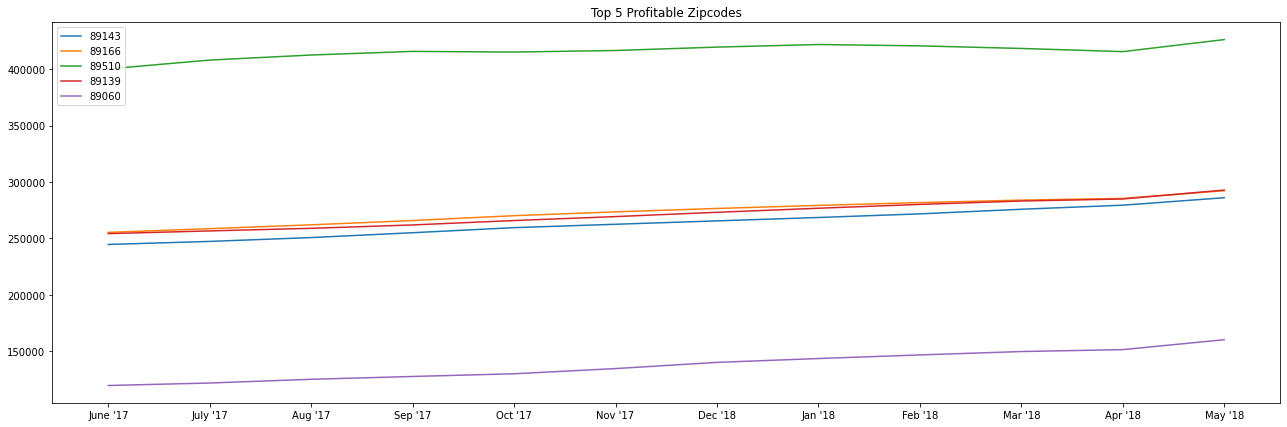

<Figure size 432x288 with 0 Axes>

In [186]:
months = ["June '17", "July '17","Aug '17","Sep '17","Oct '17","Nov '17","Dec '18","Jan '18","Feb '18","Mar '18","Apr '18", "May '18"]
fig, ax = plt.subplots(figsize=(22,7))
fig = plt.figure()

ax.plot(months, investment_chart_data[89143])
ax.plot(months, investment_chart_data[89166])
ax.plot(months, investment_chart_data[89510])
ax.plot(months, investment_chart_data[89139])
ax.plot(months, investment_chart_data[89060])



ax.set_title('Top 5 Profitable Zipcodes')
ax.legend(['89143','89166','89510','89139','89060'], loc=('upper left'));


In [248]:
df_time_series

,89108,89121,89117,89052,89123,89031,89110,89074,89103,89148,...,89444,89085,89034,89021,89439,89411,89124,89440,89413,89155
1996-04-01 00:00:00,102500.000000,106800.000000,165100.00000,185700.000,144000.00000,122800.000000,95800.000000,148000.00,118900.000000,157300.0000,...,116800.0000,170900.0,196000.0,153200.0,184200.00000,299200.0,166100.0000,293200.0,562400.000,176400.00000
1996-05-01 00:00:00,102500.000000,107000.000000,164500.00000,186300.000,143500.00000,122800.000000,95800.000000,147800.00,119000.000000,156000.0000,...,117000.0000,170800.0,196000.0,153700.0,185000.00000,299600.0,166600.0000,293200.0,562800.000,176300.00000
1996-06-01 00:00:00,102500.000000,107200.000000,164000.00000,186900.000,143100.00000,122700.000000,95800.000000,147600.00,119000.000000,154700.0000,...,117200.0000,170700.0,195900.0,154100.0,185800.00000,299900.0,167300.0000,293200.0,562700.000,176100.00000
1996-07-01 00:00:00,102600.000000,107400.000000,163500.00000,187400.000,142700.00000,122700.000000,95900.000000,147300.00,119100.000000,153500.0000,...,117400.0000,170700.0,195700.0,154400.0,186400.00000,300200.0,167900.0000,293200.0,562400.000,176000.00000
1996-08-01 00:00:00,102700.000000,107600.000000,163200.00000,187700.000,142400.00000,122700.000000,96100.000000,147100.00,119200.000000,152600.0000,...,117600.0000,170700.0,195400.0,154700.0,186900.00000,300500.0,168600.0000,293200.0,562300.000,175900.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 00:00:00,200700.000000,201500.000000,330700.00000,407300.000,294300.00000,234600.000000,189200.000000,303500.00,243700.000000,294100.0000,...,270000.0000,316500.0,315500.0,299900.0,449500.00000,642500.0,317600.0000,201600.0,2121300.000,350400.00000
2018-02-01 00:00:00,203500.000000,204000.000000,334600.00000,410400.000,297400.00000,237200.000000,191700.000000,306700.00,246300.000000,296900.0000,...,275600.0000,319500.0,319500.0,302500.0,450100.00000,653800.0,323400.0000,207000.0,2153600.000,353000.00000
2018-03-01 00:00:00,206600.000000,206700.000000,338800.00000,413700.000,300200.00000,239800.000000,194500.000000,309800.00,249500.000000,299400.0000,...,282100.0000,322400.0,323600.0,305700.0,451100.00000,666000.0,334700.0000,216500.0,2167100.000,356000.00000
2018-04-01 00:00:00,209300.000000,208600.000000,342000.00000,416100.000,302400.00000,241900.000000,196600.000000,312200.00,252000.000000,300800.0000,...,286000.0000,324700.0,326600.0,307800.0,455300.00000,672600.0,344300.0000,222800.0,2161900.000,357200.00000


In [250]:
zipcodes = df_time_series.columns
dict_mape_skylar = {}
dict_pred_skylar = {}

for zipcode in range(len(zipcodes)):

    # init a RMM model
    rnn_model = Sequential()
    # add 4 layers of RNN and a last layer

    # we define shape on first layer, (60,1) because we use 60 inputs per prediction
    rnn_model.add(LSTM(units= 60, return_sequences = False, input_shape=((60,1))))
    #rnn_model.add(Dropout(.1))

    # 3 other layers
    #rnn_model.add(LSTM(units= 30, return_sequences = True))
    #rnn_model.add(Dropout(.1))

    # return_sequence is False because we want only 1 output after this layer
    #rnn_model.add(LSTM(units= 60, return_sequences = False))
    #rnn_model.add(Dropout(.1))

    # last layer 

    rnn_model.add(Dense(units=1))

    # compile - because this is a regression model we want to minimize MSE

    rnn_model.compile(optimizer='adam', loss='mean_absolute_percentage_error')

    # We get only the specific column(Zipcode from our train and test datas)
    train_data = train.iloc[:,zipcode:zipcode+1].values.astype(int)
    test_data = test.iloc[:,zipcode:zipcode+1].values.astype(int)
    
    # We are using normalizaion rather than standascaler. 
    # In a upward trending timeseries it is better to not start from negative

    scaler = MinMaxScaler(feature_range=(0,1))
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    # Because we are using 60 previous values to model and predict the next value, 
    # We set X_train from arrays of 60 for each y_train value
    # Same idea for test data sets
    X_train = []
    y_train = []
    for i in range(60,len(train_data_scaled)):
        X_train.append(train_data_scaled[i-60:i])
        y_train.append(train_data_scaled[i])

    data_total = pd.concat((train.iloc[:,zipcode:zipcode+1], test.iloc[:,zipcode:zipcode+1]),axis=0)
    inputs = data_total[len(train)-60:].values
    inputs = scaler.transform(inputs)

    X_test = []
    y_test = []
    for i in range(60,len(inputs)):
        X_test.append(inputs[i-60:i])
        y_test.append(inputs[i])
    X_test = np.array(X_test)
    y_test = np.array(test_data)

    # We need numpy arrays for our model
    X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    
    # We fit our data to our zipcode specific data
    rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, scaler.transform(y_test)))

    # Make predictions on the data

    y_hat_raw = rnn_model.predict(X_train)
    y_hat = scaler.inverse_transform(y_hat_raw)

    # Use the score on unseen test data to calculate the MAPE

    dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))      

    # We get the last 60 values from our test data which is basically last 60 values in the data set
    last_60 = df_time_series.iloc[-60:,zipcode:zipcode+1].values.astype(int)
    
    # Before we use our data we scale it
    last_60 = scaler.transform(last_60)
    
    # Our input should be in (x,60,1) format
    x_new_pred = last_60[-60:].reshape(1,60,1)

    # make a prediction, add to the last_60 for the next prediction and 
    y_pred = rnn_model.predict(x_new_pred)

    # We add our predition to our list of predictions for zipcode specific predictions list
    dict_pred_skylar[zipcodes[zipcode]]=scaler.inverse_transform(y_pred)
    
    print(f'Iteration number {zipcode} finished')
    

Epoch 1/50
5/5 [==============================] - 0s 83ms/step - loss: 48085.5508 - val_loss: 70.4427
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 132760.1406 - val_loss: 70.2606
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 83623.4375 - val_loss: 77.6148
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 16281.0430 - val_loss: 79.2507
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 4100.2905 - val_loss: 77.4637
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 70966.1016 - val_loss: 77.3141
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 54380.8008 - val_loss: 80.6926
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 17259.9961 - val_loss: 81.6933
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 7471.9990 - val_loss: 80.0082
Epoch 10/50
5/5 [==============================] - 0s 17ms/step - loss: 55874.8086 

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 0 finished
Epoch 1/50
5/5 [==============================] - 0s 98ms/step - loss: 109346.1250 - val_loss: 110.0506
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 147550.9531 - val_loss: 105.7346
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 66764.4062 - val_loss: 106.5142
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 58314.0117 - val_loss: 110.3191
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 208475.2969 - val_loss: 107.2347
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 74132.5938 - val_loss: 101.7326
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 223629.0000 - val_loss: 100.0141
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 141416.0469 - val_loss: 103.1070
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 92367.4141 - val_loss: 106.2805
Epoch 10/50
5/5 [=======================

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 1 finished
Epoch 1/50
5/5 [==============================] - 0s 81ms/step - loss: 57.7800 - val_loss: 38.7170
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 47.7402 - val_loss: 29.1224
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 37.9042 - val_loss: 37.6954
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 32.6638 - val_loss: 33.0170
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 27.6202 - val_loss: 19.6893
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 24.5426 - val_loss: 12.7351
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 20.5773 - val_loss: 17.0647
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 18.2276 - val_loss: 7.6647
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 16.2309 - val_loss: 7.9649
Epoch 10/50
5/5 [==============================] - 0s 17ms/step - loss: 14.5134 - v

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 5 finished
Epoch 1/50
5/5 [==============================] - 0s 80ms/step - loss: 49257.1445 - val_loss: 75.1683
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 174727.6406 - val_loss: 84.2641
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 85958.7344 - val_loss: 80.4554
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 55797.0273 - val_loss: 72.5885
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 130791.7500 - val_loss: 71.1461
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 131899.7500 - val_loss: 72.8724
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 88555.0078 - val_loss: 78.7432
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 15554.0703 - val_loss: 81.7803
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 13656.5234 - val_loss: 80.5230
Epoch 10/50
5/5 [==============================] - 

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 6 finished
Epoch 1/50
5/5 [==============================] - 0s 81ms/step - loss: 70.4585 - val_loss: 52.4626
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 59.8631 - val_loss: 31.5861
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 49.1708 - val_loss: 41.0355
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 40.6009 - val_loss: 43.9696
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 35.5320 - val_loss: 34.5629
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 29.5127 - val_loss: 18.7960
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 27.6072 - val_loss: 16.7483
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 24.6715 - val_loss: 20.5479
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 21.0080 - val_loss: 10.8983
Epoch 10/50
5/5 [==============================] - 0s 17ms/step - loss: 19.0879 -

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 8 finished
Epoch 1/50
5/5 [==============================] - 0s 81ms/step - loss: 87.3541 - val_loss: 72.9971
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 66.2597 - val_loss: 51.4525
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 50.9399 - val_loss: 54.0616
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 44.4303 - val_loss: 43.8415
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 35.9074 - val_loss: 23.3005
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 32.1542 - val_loss: 22.6162
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 28.0417 - val_loss: 21.8710
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 25.1126 - val_loss: 7.8102
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 24.0170 - val_loss: 11.4138
Epoch 10/50
5/5 [==============================] - 0s 17ms/step - loss: 22.6644 - 

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 10 finished
Epoch 1/50
5/5 [==============================] - 0s 79ms/step - loss: 89954.0078 - val_loss: 91.2521
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 99238.4531 - val_loss: 99.0914
Epoch 3/50
5/5 [==============================] - 0s 18ms/step - loss: 201925.3125 - val_loss: 100.8140
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 85286.3672 - val_loss: 96.2172
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 64518.0117 - val_loss: 89.8943
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 223559.5469 - val_loss: 90.6342
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 140403.8281 - val_loss: 94.7843
Epoch 8/50
5/5 [==============================] - 0s 19ms/step - loss: 57481.1719 - val_loss: 98.8798
Epoch 9/50
5/5 [==============================] - 0s 20ms/step - loss: 100805.9766 - val_loss: 97.8058
Epoch 10/50
5/5 [==============================]

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 11 finished
Epoch 1/50
5/5 [==============================] - 1s 107ms/step - loss: 69382.6797 - val_loss: 115.0790
Epoch 2/50
5/5 [==============================] - 0s 23ms/step - loss: 606383.5625 - val_loss: 114.7181
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 439804.6875 - val_loss: 102.6088
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 111621.2891 - val_loss: 90.8820
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 267555.8750 - val_loss: 88.5235
Epoch 6/50
5/5 [==============================] - 0s 22ms/step - loss: 230514.0000 - val_loss: 91.4206
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 82716.3828 - val_loss: 96.3592
Epoch 8/50
5/5 [==============================] - 0s 23ms/step - loss: 14539.1484 - val_loss: 95.2976
Epoch 9/50
5/5 [==============================] - 0s 21ms/step - loss: 49433.7656 - val_loss: 96.6296
Epoch 10/50
5/5 [===========================

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 12 finished
Epoch 1/50
5/5 [==============================] - 0s 84ms/step - loss: 92802.8828 - val_loss: 74.1958
Epoch 2/50
5/5 [==============================] - 0s 22ms/step - loss: 79310.2578 - val_loss: 70.2526
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 58440.7109 - val_loss: 80.2672
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 231945.5312 - val_loss: 84.1281
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 171110.0156 - val_loss: 78.5308
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 35661.2188 - val_loss: 77.9873
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 19114.3809 - val_loss: 79.6024
Epoch 8/50
5/5 [==============================] - 0s 19ms/step - loss: 8762.4482 - val_loss: 80.5365
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 16172.6436 - val_loss: 81.2652
Epoch 10/50
5/5 [==============================] - 0

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 13 finished
Epoch 1/50
5/5 [==============================] - 0s 89ms/step - loss: 57503.3672 - val_loss: 112.4765
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 140512.6875 - val_loss: 118.7352
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 75079.7891 - val_loss: 111.9488
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 48358.2812 - val_loss: 107.3479
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 18020.6621 - val_loss: 109.9244
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 61944.6914 - val_loss: 113.4867
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 57475.7969 - val_loss: 110.0753
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 8094.8267 - val_loss: 110.0736
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 6239.7852 - val_loss: 109.4091
Epoch 10/50
5/5 [============================

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 14 finished
Epoch 1/50
5/5 [==============================] - 0s 82ms/step - loss: 181269.4062 - val_loss: 93.4778
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 38251.5156 - val_loss: 106.1953
Epoch 3/50
5/5 [==============================] - 0s 18ms/step - loss: 198152.3906 - val_loss: 108.3581
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 167681.2812 - val_loss: 105.2836
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 92015.1016 - val_loss: 101.0465
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 33380.8438 - val_loss: 95.8060
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 101150.6406 - val_loss: 94.3402
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 98898.3438 - val_loss: 95.9631
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 47243.5391 - val_loss: 98.2394
Epoch 10/50
5/5 [============================

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 15 finished
Epoch 1/50
5/5 [==============================] - 0s 81ms/step - loss: 165662.0312 - val_loss: 89.5539
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 22987.8359 - val_loss: 82.0533
Epoch 3/50
5/5 [==============================] - 0s 18ms/step - loss: 218758.7031 - val_loss: 81.3942
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 160197.0781 - val_loss: 86.5392
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 20985.9648 - val_loss: 90.4471
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 110703.3828 - val_loss: 89.6232
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 24847.2344 - val_loss: 85.9972
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 143979.3906 - val_loss: 84.5754
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 103860.0156 - val_loss: 88.2952
Epoch 10/50
5/5 [==============================

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 16 finished
Epoch 1/50
5/5 [==============================] - 0s 81ms/step - loss: 56.6403 - val_loss: 38.5349
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 47.0222 - val_loss: 29.0525
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 36.1224 - val_loss: 39.8124
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 31.3014 - val_loss: 37.2615
Epoch 5/50
5/5 [==============================] - 0s 19ms/step - loss: 26.4646 - val_loss: 21.7475
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 24.3540 - val_loss: 16.6117
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 19.9016 - val_loss: 17.6374
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 17.4000 - val_loss: 8.5512
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 14.3573 - val_loss: 3.8554
Epoch 10/50
5/5 [==============================] - 0s 19ms/step - loss: 14.4430 - 

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 19 finished
Epoch 1/50
5/5 [==============================] - 0s 94ms/step - loss: 132811.0469 - val_loss: 104.2077
Epoch 2/50
5/5 [==============================] - 0s 38ms/step - loss: 12482.8828 - val_loss: 116.7451
Epoch 3/50
5/5 [==============================] - 0s 32ms/step - loss: 143918.1250 - val_loss: 116.2581
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 136116.2031 - val_loss: 113.3111
Epoch 5/50
5/5 [==============================] - 0s 24ms/step - loss: 90635.6094 - val_loss: 107.4156
Epoch 6/50
5/5 [==============================] - 0s 24ms/step - loss: 34679.5156 - val_loss: 106.0415
Epoch 7/50
5/5 [==============================] - 0s 25ms/step - loss: 22227.7559 - val_loss: 107.3698
Epoch 8/50
5/5 [==============================] - 0s 26ms/step - loss: 1941.7555 - val_loss: 107.0395
Epoch 9/50
5/5 [==============================] - 0s 23ms/step - loss: 3081.8630 - val_loss: 108.6687
Epoch 10/50
5/5 [==========================

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 20 finished
Epoch 1/50
5/5 [==============================] - 1s 163ms/step - loss: 153036.5938 - val_loss: 91.0811
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 51344.8867 - val_loss: 94.5889
Epoch 3/50
5/5 [==============================] - 0s 18ms/step - loss: 11474.7021 - val_loss: 88.9247
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 82364.7734 - val_loss: 87.4663
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 67666.9844 - val_loss: 91.1752
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 13824.7666 - val_loss: 96.8132
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 99244.3750 - val_loss: 98.1420
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 82364.0781 - val_loss: 97.0751
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 27235.7461 - val_loss: 93.0124
Epoch 10/50
5/5 [==============================] - 

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 21 finished
Epoch 1/50
5/5 [==============================] - 0s 86ms/step - loss: 75.9538 - val_loss: 60.6610
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 40.7564 - val_loss: 24.6694
Epoch 3/50
5/5 [==============================] - 0s 18ms/step - loss: 39.0600 - val_loss: 30.1170
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 29.8222 - val_loss: 37.0989
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 27.7230 - val_loss: 26.6163
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 22.9384 - val_loss: 14.0634
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 21.1100 - val_loss: 21.6008
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 18.9889 - val_loss: 12.6067
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 16.4311 - val_loss: 9.6227
Epoch 10/50
5/5 [==============================] - 0s 17ms/step - loss: 14.9490 -

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 23 finished
Epoch 1/50
5/5 [==============================] - 0s 82ms/step - loss: 80.4739 - val_loss: 57.8881
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 33.6353 - val_loss: 11.9251
Epoch 3/50
5/5 [==============================] - 0s 18ms/step - loss: 36.7496 - val_loss: 22.0174
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 25.3321 - val_loss: 34.3443
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 24.0986 - val_loss: 27.9146
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 19.1588 - val_loss: 14.7260
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 17.9839 - val_loss: 11.8057
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 14.6866 - val_loss: 14.7944
Epoch 9/50
5/5 [==============================] - 0s 19ms/step - loss: 11.8731 - val_loss: 5.3641
Epoch 10/50
5/5 [==============================] - 0s 19ms/step - loss: 10.5403 -

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 25 finished
Epoch 1/50
5/5 [==============================] - 0s 80ms/step - loss: 122910.2266 - val_loss: 106.6814
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 127596.5625 - val_loss: 105.4160
Epoch 3/50
5/5 [==============================] - 0s 18ms/step - loss: 62446.4336 - val_loss: 100.5896
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 7725.1836 - val_loss: 100.5872
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 860.6899 - val_loss: 103.1105
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 83630.2500 - val_loss: 103.8015
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 47875.1328 - val_loss: 101.9382
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 26568.8398 - val_loss: 96.3695
Epoch 9/50
5/5 [==============================] - 0s 19ms/step - loss: 98973.7266 - val_loss: 95.5603
Epoch 10/50
5/5 [==============================

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 26 finished
Epoch 1/50
5/5 [==============================] - 1s 218ms/step - loss: 107363.6328 - val_loss: 100.0468
Epoch 2/50
5/5 [==============================] - 0s 32ms/step - loss: 75528.2500 - val_loss: 102.7378
Epoch 3/50
5/5 [==============================] - 0s 32ms/step - loss: 25727.3027 - val_loss: 100.0184
Epoch 4/50
5/5 [==============================] - 0s 31ms/step - loss: 58383.7695 - val_loss: 96.3767
Epoch 5/50
5/5 [==============================] - 0s 32ms/step - loss: 55118.4570 - val_loss: 98.9474
Epoch 6/50
5/5 [==============================] - 0s 26ms/step - loss: 7265.3379 - val_loss: 100.0708
Epoch 7/50
5/5 [==============================] - 0s 30ms/step - loss: 6989.7461 - val_loss: 101.5237
Epoch 8/50
5/5 [==============================] - 0s 35ms/step - loss: 18502.2773 - val_loss: 100.0611
Epoch 9/50
5/5 [==============================] - 0s 39ms/step - loss: 10129.7227 - val_loss: 101.5715
Epoch 10/50
5/5 [=============================

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 27 finished
Epoch 1/50
5/5 [==============================] - 1s 116ms/step - loss: 196378.4219 - val_loss: 92.3783
Epoch 2/50
5/5 [==============================] - 0s 26ms/step - loss: 84537.9375 - val_loss: 97.5313
Epoch 3/50
5/5 [==============================] - 0s 26ms/step - loss: 63485.2695 - val_loss: 88.9814
Epoch 4/50
5/5 [==============================] - 0s 26ms/step - loss: 111916.2891 - val_loss: 87.3583
Epoch 5/50
5/5 [==============================] - 0s 22ms/step - loss: 99307.3594 - val_loss: 90.7091
Epoch 6/50
5/5 [==============================] - 0s 24ms/step - loss: 33813.1953 - val_loss: 95.3416
Epoch 7/50
5/5 [==============================] - 0s 25ms/step - loss: 73675.5547 - val_loss: 97.2720
Epoch 8/50
5/5 [==============================] - 0s 24ms/step - loss: 66865.6016 - val_loss: 95.0586
Epoch 9/50
5/5 [==============================] - 0s 23ms/step - loss: 657.3619 - val_loss: 94.4063
Epoch 10/50
5/5 [==============================] - 0

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 28 finished
Epoch 1/50
5/5 [==============================] - 1s 104ms/step - loss: 73398.9375 - val_loss: 117.6777
Epoch 2/50
5/5 [==============================] - 0s 29ms/step - loss: 146707.6250 - val_loss: 113.6285
Epoch 3/50
5/5 [==============================] - 0s 27ms/step - loss: 91152.2188 - val_loss: 105.7094
Epoch 4/50
5/5 [==============================] - 0s 25ms/step - loss: 35239.8906 - val_loss: 105.8260
Epoch 5/50
5/5 [==============================] - 0s 25ms/step - loss: 14744.4736 - val_loss: 111.0109
Epoch 6/50
5/5 [==============================] - 0s 23ms/step - loss: 63356.9922 - val_loss: 109.8432
Epoch 7/50
5/5 [==============================] - 0s 24ms/step - loss: 46074.7617 - val_loss: 105.4575
Epoch 8/50
5/5 [==============================] - 0s 26ms/step - loss: 19472.8750 - val_loss: 106.4617
Epoch 9/50
5/5 [==============================] - 0s 25ms/step - loss: 5163.8818 - val_loss: 105.9675
Epoch 10/50
5/5 [==========================

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 29 finished
Epoch 1/50
5/5 [==============================] - 1s 116ms/step - loss: 25973.3496 - val_loss: 105.7352
Epoch 2/50
5/5 [==============================] - 0s 24ms/step - loss: 231964.0312 - val_loss: 104.3488
Epoch 3/50
5/5 [==============================] - 0s 23ms/step - loss: 169784.6250 - val_loss: 97.8519
Epoch 4/50
5/5 [==============================] - 0s 24ms/step - loss: 38734.7188 - val_loss: 90.9839
Epoch 5/50
5/5 [==============================] - 0s 24ms/step - loss: 100655.0625 - val_loss: 89.3774
Epoch 6/50
5/5 [==============================] - 0s 31ms/step - loss: 82152.9844 - val_loss: 92.0611
Epoch 7/50
5/5 [==============================] - 0s 30ms/step - loss: 8911.4619 - val_loss: 95.5398
Epoch 8/50
5/5 [==============================] - 0s 23ms/step - loss: 67644.9609 - val_loss: 97.6525
Epoch 9/50
5/5 [==============================] - 0s 26ms/step - loss: 66125.1797 - val_loss: 95.5910
Epoch 10/50
5/5 [==============================]

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 30 finished
Epoch 1/50
5/5 [==============================] - 0s 89ms/step - loss: 34930.6211 - val_loss: 84.6999
Epoch 2/50
5/5 [==============================] - 0s 22ms/step - loss: 340086.2500 - val_loss: 79.1136
Epoch 3/50
5/5 [==============================] - 0s 22ms/step - loss: 252168.3125 - val_loss: 88.6945
Epoch 4/50
5/5 [==============================] - 0s 20ms/step - loss: 126351.1562 - val_loss: 97.7109
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 11111.7139 - val_loss: 99.9667
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 27546.0234 - val_loss: 98.5993
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 9395.9346 - val_loss: 99.1554
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 7589.9624 - val_loss: 97.2627
Epoch 9/50
5/5 [==============================] - 0s 21ms/step - loss: 42934.8008 - val_loss: 96.9396
Epoch 10/50
5/5 [==============================] - 0

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 31 finished
Epoch 1/50
5/5 [==============================] - 0s 96ms/step - loss: 76.6168 - val_loss: 57.0204
Epoch 2/50
5/5 [==============================] - 0s 24ms/step - loss: 49.1868 - val_loss: 32.5022
Epoch 3/50
5/5 [==============================] - 0s 26ms/step - loss: 42.7768 - val_loss: 38.5178
Epoch 4/50
5/5 [==============================] - 0s 25ms/step - loss: 33.7367 - val_loss: 35.2200
Epoch 5/50
5/5 [==============================] - 0s 26ms/step - loss: 27.7363 - val_loss: 22.5146
Epoch 6/50
5/5 [==============================] - 0s 25ms/step - loss: 24.3326 - val_loss: 15.1913
Epoch 7/50
5/5 [==============================] - 0s 27ms/step - loss: 21.3988 - val_loss: 15.5885
Epoch 8/50
5/5 [==============================] - 0s 59ms/step - loss: 17.3572 - val_loss: 4.6548
Epoch 9/50
5/5 [==============================] - 0s 32ms/step - loss: 17.0866 - val_loss: 7.5897
Epoch 10/50
5/5 [==============================] - 0s 32ms/step - loss: 16.0613 - 

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 35 finished
Epoch 1/50
5/5 [==============================] - 0s 90ms/step - loss: 74.9444 - val_loss: 53.6921
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 31.5734 - val_loss: 10.4871
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 30.9982 - val_loss: 20.0084
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 21.9976 - val_loss: 34.2115
Epoch 5/50
5/5 [==============================] - 0s 24ms/step - loss: 21.4110 - val_loss: 27.9614
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 16.9837 - val_loss: 16.3684
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 15.6667 - val_loss: 14.4351
Epoch 8/50
5/5 [==============================] - 0s 21ms/step - loss: 13.0501 - val_loss: 16.3184
Epoch 9/50
5/5 [==============================] - 0s 22ms/step - loss: 11.2252 - val_loss: 7.0235
Epoch 10/50
5/5 [==============================] - 0s 21ms/step - loss: 9.9505 - 

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 37 finished
Epoch 1/50
5/5 [==============================] - 1s 113ms/step - loss: 80.3972 - val_loss: 60.5375
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 33.7020 - val_loss: 12.3397
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 24.5539 - val_loss: 8.3108
Epoch 4/50
5/5 [==============================] - 0s 20ms/step - loss: 16.1635 - val_loss: 25.2467
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 17.2891 - val_loss: 24.4149
Epoch 6/50
5/5 [==============================] - 0s 22ms/step - loss: 13.6934 - val_loss: 12.3801
Epoch 7/50
5/5 [==============================] - 0s 22ms/step - loss: 13.4342 - val_loss: 9.5630
Epoch 8/50
5/5 [==============================] - 0s 22ms/step - loss: 11.7376 - val_loss: 14.3259
Epoch 9/50
5/5 [==============================] - 0s 22ms/step - loss: 10.4690 - val_loss: 13.5191
Epoch 10/50
5/5 [==============================] - 0s 23ms/step - loss: 9.5815 - 

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 40 finished
Epoch 1/50
5/5 [==============================] - 0s 91ms/step - loss: 89.2396 - val_loss: 79.9889
Epoch 2/50
5/5 [==============================] - 0s 24ms/step - loss: 71.4865 - val_loss: 59.9108
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 54.9297 - val_loss: 39.2189
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 44.1042 - val_loss: 30.0093
Epoch 5/50
5/5 [==============================] - 0s 22ms/step - loss: 41.2326 - val_loss: 27.2603
Epoch 6/50
5/5 [==============================] - 0s 23ms/step - loss: 36.3825 - val_loss: 27.0408
Epoch 7/50
5/5 [==============================] - 0s 25ms/step - loss: 33.3034 - val_loss: 18.6167
Epoch 8/50
5/5 [==============================] - 0s 25ms/step - loss: 30.3946 - val_loss: 16.6792
Epoch 9/50
5/5 [==============================] - 0s 25ms/step - loss: 29.2299 - val_loss: 13.9191
Epoch 10/50
5/5 [==============================] - 0s 32ms/step - loss: 25.7257 

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 42 finished
Epoch 1/50
5/5 [==============================] - 1s 104ms/step - loss: 256592.0781 - val_loss: 88.8412
Epoch 2/50
5/5 [==============================] - 0s 28ms/step - loss: 160702.6719 - val_loss: 102.2349
Epoch 3/50
5/5 [==============================] - 0s 28ms/step - loss: 91952.8438 - val_loss: 107.7032
Epoch 4/50
5/5 [==============================] - 0s 29ms/step - loss: 70800.0078 - val_loss: 104.4489
Epoch 5/50
5/5 [==============================] - 0s 29ms/step - loss: 23071.0020 - val_loss: 99.1375
Epoch 6/50
5/5 [==============================] - 0s 29ms/step - loss: 84339.9922 - val_loss: 98.3456
Epoch 7/50
5/5 [==============================] - 0s 27ms/step - loss: 82554.7891 - val_loss: 100.2561
Epoch 8/50
5/5 [==============================] - 0s 26ms/step - loss: 45888.0117 - val_loss: 103.7374
Epoch 9/50
5/5 [==============================] - 0s 26ms/step - loss: 52056.9453 - val_loss: 104.9923
Epoch 10/50
5/5 [===========================

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 43 finished
Epoch 1/50
5/5 [==============================] - 1s 102ms/step - loss: 99.0915 - val_loss: 79.4526
Epoch 2/50
5/5 [==============================] - 0s 25ms/step - loss: 51.7472 - val_loss: 42.4144
Epoch 3/50
5/5 [==============================] - 0s 25ms/step - loss: 45.1770 - val_loss: 38.6349
Epoch 4/50
5/5 [==============================] - 0s 28ms/step - loss: 35.6801 - val_loss: 38.7392
Epoch 5/50
5/5 [==============================] - 0s 31ms/step - loss: 30.3373 - val_loss: 31.3958
Epoch 6/50
5/5 [==============================] - 0s 28ms/step - loss: 25.3594 - val_loss: 20.4785
Epoch 7/50
5/5 [==============================] - 0s 25ms/step - loss: 20.5827 - val_loss: 15.9866
Epoch 8/50
5/5 [==============================] - 0s 24ms/step - loss: 16.8204 - val_loss: 7.6393
Epoch 9/50
5/5 [==============================] - 0s 28ms/step - loss: 15.5307 - val_loss: 5.0218
Epoch 10/50
5/5 [==============================] - 0s 26ms/step - loss: 14.0348 -

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 46 finished
Epoch 1/50
5/5 [==============================] - 1s 100ms/step - loss: 200494.7500 - val_loss: 86.8451
Epoch 2/50
5/5 [==============================] - 0s 22ms/step - loss: 3865.9946 - val_loss: 92.5481
Epoch 3/50
5/5 [==============================] - 0s 23ms/step - loss: 10625.1797 - val_loss: 94.1222
Epoch 4/50
5/5 [==============================] - 0s 24ms/step - loss: 14306.5293 - val_loss: 92.3947
Epoch 5/50
5/5 [==============================] - 0s 23ms/step - loss: 32358.6914 - val_loss: 93.3411
Epoch 6/50
5/5 [==============================] - 0s 22ms/step - loss: 1169.6337 - val_loss: 96.0558
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 62278.9414 - val_loss: 96.8926
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 51797.3164 - val_loss: 94.6548
Epoch 9/50
5/5 [==============================] - 0s 24ms/step - loss: 6918.2720 - val_loss: 90.8581
Epoch 10/50
5/5 [==============================] - 0s 

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 47 finished
Epoch 1/50
5/5 [==============================] - 0s 92ms/step - loss: 0.0000e+00 - val_loss: 96.2253
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - val_loss: 96.2253
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - val_loss: 96.2253
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - val_loss: 96.2253
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - val_loss: 96.2253
Epoch 6/50
5/5 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - val_loss: 96.2253
Epoch 7/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - val_loss: 96.2253
Epoch 8/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - val_loss: 96.2253
Epoch 9/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - val_loss: 96.2253
Epoch 10/50
5/5 [==============================] - 0s

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 48 finished
Epoch 1/50
5/5 [==============================] - 0s 99ms/step - loss: 112121.9453 - val_loss: 115.9916
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 62823.2188 - val_loss: 115.0217
Epoch 3/50
5/5 [==============================] - 0s 22ms/step - loss: 5932.9595 - val_loss: 110.4111
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 37400.7383 - val_loss: 110.0231
Epoch 5/50
5/5 [==============================] - 0s 22ms/step - loss: 34892.8867 - val_loss: 112.2965
Epoch 6/50
5/5 [==============================] - 0s 25ms/step - loss: 35556.7344 - val_loss: 113.1559
Epoch 7/50
5/5 [==============================] - 0s 25ms/step - loss: 17361.1797 - val_loss: 108.8143
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 83129.5859 - val_loss: 106.7023
Epoch 9/50
5/5 [==============================] - 0s 22ms/step - loss: 65746.9453 - val_loss: 110.7621
Epoch 10/50
5/5 [===========================

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 49 finished
Epoch 1/50
5/5 [==============================] - 0s 90ms/step - loss: 68.6432 - val_loss: 49.1721
Epoch 2/50
5/5 [==============================] - 0s 22ms/step - loss: 43.8220 - val_loss: 25.8666
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 37.8151 - val_loss: 30.8987
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 28.8314 - val_loss: 33.6151
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 25.1011 - val_loss: 18.5252
Epoch 6/50
5/5 [==============================] - 0s 21ms/step - loss: 22.8744 - val_loss: 11.7562
Epoch 7/50
5/5 [==============================] - 0s 23ms/step - loss: 18.7063 - val_loss: 17.1232
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 15.5748 - val_loss: 3.2887
Epoch 9/50
5/5 [==============================] - 0s 23ms/step - loss: 14.1424 - val_loss: 5.6289
Epoch 10/50
5/5 [==============================] - 0s 36ms/step - loss: 13.4538 - 

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 52 finished
Epoch 1/50
5/5 [==============================] - 0s 99ms/step - loss: 10622.6953 - val_loss: 109.2208
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 169230.2344 - val_loss: 105.7361
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 132609.6250 - val_loss: 112.8179
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 14521.8984 - val_loss: 121.0970
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 114422.7500 - val_loss: 120.5193
Epoch 6/50
5/5 [==============================] - 0s 22ms/step - loss: 106797.3047 - val_loss: 118.8924
Epoch 7/50
5/5 [==============================] - 0s 22ms/step - loss: 26359.1113 - val_loss: 113.1940
Epoch 8/50
5/5 [==============================] - 0s 22ms/step - loss: 895.5901 - val_loss: 110.0983
Epoch 9/50
5/5 [==============================] - 0s 21ms/step - loss: 46424.9688 - val_loss: 111.0575
Epoch 10/50
5/5 [=========================

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 53 finished
Epoch 1/50
5/5 [==============================] - 0s 83ms/step - loss: 82.5169 - val_loss: 58.7989
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 33.1647 - val_loss: 9.1541
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 30.8248 - val_loss: 19.5209
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 21.8246 - val_loss: 33.5588
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 23.6361 - val_loss: 31.4300
Epoch 6/50
5/5 [==============================] - 0s 21ms/step - loss: 20.3354 - val_loss: 17.4711
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 18.7770 - val_loss: 13.0562
Epoch 8/50
5/5 [==============================] - 0s 21ms/step - loss: 16.5652 - val_loss: 17.6803
Epoch 9/50
5/5 [==============================] - 0s 20ms/step - loss: 15.4720 - val_loss: 19.4386
Epoch 10/50
5/5 [==============================] - 0s 21ms/step - loss: 14.0119 -

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 55 finished
Epoch 1/50
5/5 [==============================] - 1s 102ms/step - loss: 49851.9531 - val_loss: 126.5642
Epoch 2/50
5/5 [==============================] - 0s 27ms/step - loss: 128560.6953 - val_loss: 122.3995
Epoch 3/50
5/5 [==============================] - 0s 27ms/step - loss: 58325.7422 - val_loss: 119.0095
Epoch 4/50
5/5 [==============================] - 0s 28ms/step - loss: 14064.6689 - val_loss: 110.6261
Epoch 5/50
5/5 [==============================] - 0s 31ms/step - loss: 140257.8281 - val_loss: 106.9037
Epoch 6/50
5/5 [==============================] - 0s 25ms/step - loss: 135895.6719 - val_loss: 107.6487
Epoch 7/50
5/5 [==============================] - 0s 30ms/step - loss: 87954.9609 - val_loss: 110.2445
Epoch 8/50
5/5 [==============================] - 0s 28ms/step - loss: 33434.3633 - val_loss: 114.0679
Epoch 9/50
5/5 [==============================] - 0s 25ms/step - loss: 31030.8613 - val_loss: 115.1070
Epoch 10/50
5/5 [=======================

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 56 finished
Epoch 1/50
5/5 [==============================] - 0s 96ms/step - loss: 150637.0469 - val_loss: 60.4213
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 7843.4517 - val_loss: 78.2517
Epoch 3/50
5/5 [==============================] - 0s 24ms/step - loss: 279397.3125 - val_loss: 86.6454
Epoch 4/50
5/5 [==============================] - 0s 23ms/step - loss: 261473.6094 - val_loss: 81.3868
Epoch 5/50
5/5 [==============================] - 0s 23ms/step - loss: 122426.0781 - val_loss: 76.5772
Epoch 6/50
5/5 [==============================] - 0s 22ms/step - loss: 9731.7227 - val_loss: 74.9318
Epoch 7/50
5/5 [==============================] - 0s 23ms/step - loss: 3858.7952 - val_loss: 77.3545
Epoch 8/50
5/5 [==============================] - 0s 22ms/step - loss: 55303.1719 - val_loss: 78.6021
Epoch 9/50
5/5 [==============================] - 0s 22ms/step - loss: 36227.7422 - val_loss: 77.0980
Epoch 10/50
5/5 [==============================] - 0

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 57 finished
Epoch 1/50
5/5 [==============================] - 0s 85ms/step - loss: 85.0218 - val_loss: 63.3569
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 35.9170 - val_loss: 15.1152
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 31.5831 - val_loss: 16.9278
Epoch 4/50
5/5 [==============================] - 0s 20ms/step - loss: 24.0383 - val_loss: 29.0915
Epoch 5/50
5/5 [==============================] - 0s 19ms/step - loss: 20.3073 - val_loss: 24.1956
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 17.1224 - val_loss: 15.7648
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 15.0179 - val_loss: 14.7492
Epoch 8/50
5/5 [==============================] - 0s 19ms/step - loss: 12.7749 - val_loss: 14.3257
Epoch 9/50
5/5 [==============================] - 0s 20ms/step - loss: 10.2451 - val_loss: 10.6457
Epoch 10/50
5/5 [==============================] - 0s 19ms/step - loss: 8.2244 -

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 59 finished
Epoch 1/50
5/5 [==============================] - 1s 138ms/step - loss: 74.1189 - val_loss: 49.7629
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 35.4840 - val_loss: 12.2132
Epoch 3/50
5/5 [==============================] - 0s 23ms/step - loss: 31.3260 - val_loss: 25.1044
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 24.8393 - val_loss: 31.8078
Epoch 5/50
5/5 [==============================] - 0s 23ms/step - loss: 22.9921 - val_loss: 23.3178
Epoch 6/50
5/5 [==============================] - 0s 23ms/step - loss: 19.4667 - val_loss: 15.9892
Epoch 7/50
5/5 [==============================] - 0s 22ms/step - loss: 18.0315 - val_loss: 15.1514
Epoch 8/50
5/5 [==============================] - 0s 22ms/step - loss: 14.8656 - val_loss: 16.9423
Epoch 9/50
5/5 [==============================] - 0s 23ms/step - loss: 12.4340 - val_loss: 7.1974
Epoch 10/50
5/5 [==============================] - 0s 23ms/step - loss: 10.9612 

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 62 finished
Epoch 1/50
5/5 [==============================] - 0s 89ms/step - loss: 74.7477 - val_loss: 54.1404
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 33.1222 - val_loss: 6.6230
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 27.6610 - val_loss: 21.1870
Epoch 4/50
5/5 [==============================] - 0s 23ms/step - loss: 20.1457 - val_loss: 28.9997
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 19.6697 - val_loss: 20.1265
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 17.3615 - val_loss: 13.1896
Epoch 7/50
5/5 [==============================] - 0s 23ms/step - loss: 15.6025 - val_loss: 18.6230
Epoch 8/50
5/5 [==============================] - 0s 23ms/step - loss: 13.8314 - val_loss: 12.7490
Epoch 9/50
5/5 [==============================] - 0s 22ms/step - loss: 12.8602 - val_loss: 13.0877
Epoch 10/50
5/5 [==============================] - 0s 22ms/step - loss: 11.6708 -

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 64 finished
Epoch 1/50
5/5 [==============================] - 0s 85ms/step - loss: 28120.7637 - val_loss: 107.1560
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 100352.4844 - val_loss: 104.6785
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 55939.1172 - val_loss: 100.2706
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 52043.3477 - val_loss: 98.8414
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 39130.8008 - val_loss: 102.3630
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 34011.8164 - val_loss: 101.8847
Epoch 7/50
5/5 [==============================] - 0s 20ms/step - loss: 20719.4844 - val_loss: 100.1943
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 30149.3555 - val_loss: 99.8512
Epoch 9/50
5/5 [==============================] - 0s 19ms/step - loss: 14238.3105 - val_loss: 101.5371
Epoch 10/50
5/5 [============================

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 65 finished
Epoch 1/50
5/5 [==============================] - 1s 114ms/step - loss: 90.4844 - val_loss: 70.1912
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 42.0088 - val_loss: 19.8513
Epoch 3/50
5/5 [==============================] - 0s 23ms/step - loss: 32.1752 - val_loss: 22.0390
Epoch 4/50
5/5 [==============================] - 0s 23ms/step - loss: 24.9721 - val_loss: 30.4013
Epoch 5/50
5/5 [==============================] - 0s 27ms/step - loss: 21.9063 - val_loss: 21.6125
Epoch 6/50
5/5 [==============================] - 0s 22ms/step - loss: 19.3314 - val_loss: 13.9611
Epoch 7/50
5/5 [==============================] - 0s 24ms/step - loss: 17.5246 - val_loss: 16.5372
Epoch 8/50
5/5 [==============================] - 0s 23ms/step - loss: 15.4696 - val_loss: 14.4114
Epoch 9/50
5/5 [==============================] - 0s 22ms/step - loss: 14.2927 - val_loss: 12.0946
Epoch 10/50
5/5 [==============================] - 0s 22ms/step - loss: 12.3110

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 71 finished
Epoch 1/50
5/5 [==============================] - 1s 129ms/step - loss: 144143.2656 - val_loss: 93.9451
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 69968.9062 - val_loss: 100.1026
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 26892.1719 - val_loss: 90.8044
Epoch 4/50
5/5 [==============================] - 0s 20ms/step - loss: 38868.5898 - val_loss: 91.0355
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 35463.1367 - val_loss: 97.3786
Epoch 6/50
5/5 [==============================] - 0s 21ms/step - loss: 46888.4648 - val_loss: 98.4309
Epoch 7/50
5/5 [==============================] - 0s 22ms/step - loss: 16361.8682 - val_loss: 93.4078
Epoch 8/50
5/5 [==============================] - 0s 21ms/step - loss: 28180.8184 - val_loss: 92.2023
Epoch 9/50
5/5 [==============================] - 0s 21ms/step - loss: 26305.8691 - val_loss: 95.7460
Epoch 10/50
5/5 [==============================] -

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 72 finished
Epoch 1/50
5/5 [==============================] - 0s 87ms/step - loss: 1720354.8750 - val_loss: 82.2321
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 685483.5000 - val_loss: 91.2005
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 212590.4219 - val_loss: 96.3483
Epoch 4/50
5/5 [==============================] - 0s 20ms/step - loss: 178496.6094 - val_loss: 92.4116
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 319647.3750 - val_loss: 91.6452
Epoch 6/50
5/5 [==============================] - 0s 21ms/step - loss: 186630.5000 - val_loss: 94.6161
Epoch 7/50
5/5 [==============================] - 0s 22ms/step - loss: 230631.7344 - val_loss: 96.3033
Epoch 8/50
5/5 [==============================] - 0s 21ms/step - loss: 125621.9453 - val_loss: 92.5802
Epoch 9/50
5/5 [==============================] - 0s 21ms/step - loss: 309478.0312 - val_loss: 91.6552
Epoch 10/50
5/5 [==========================

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 73 finished
Epoch 1/50
5/5 [==============================] - 0s 89ms/step - loss: 225389.8750 - val_loss: 71.9609
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 22902.4336 - val_loss: 83.0532
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 101306.1016 - val_loss: 89.0479
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 129553.8281 - val_loss: 87.4517
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 76447.8594 - val_loss: 84.2368
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 12305.0674 - val_loss: 82.7449
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 5423.2817 - val_loss: 82.5881
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 52382.4336 - val_loss: 80.9033
Epoch 9/50
5/5 [==============================] - 0s 19ms/step - loss: 26259.2676 - val_loss: 83.2964
Epoch 10/50
5/5 [==============================] - 

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 74 finished
Epoch 1/50
5/5 [==============================] - 0s 86ms/step - loss: 62.9749 - val_loss: 46.3094
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 29.8969 - val_loss: 10.8919
Epoch 3/50
5/5 [==============================] - 0s 23ms/step - loss: 33.4016 - val_loss: 16.0011
Epoch 4/50
5/5 [==============================] - 0s 20ms/step - loss: 23.6175 - val_loss: 26.9077
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 20.3578 - val_loss: 19.9647
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 16.5587 - val_loss: 7.5501
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 13.7214 - val_loss: 12.0906
Epoch 8/50
5/5 [==============================] - 0s 19ms/step - loss: 10.5421 - val_loss: 4.5994
Epoch 9/50
5/5 [==============================] - 0s 20ms/step - loss: 8.7304 - val_loss: 6.7494
Epoch 10/50
5/5 [==============================] - 0s 20ms/step - loss: 8.9400 - val

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 77 finished
Epoch 1/50
5/5 [==============================] - 0s 84ms/step - loss: 81.7749 - val_loss: 64.6692
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 60.8235 - val_loss: 46.4818
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 42.4123 - val_loss: 44.0478
Epoch 4/50
5/5 [==============================] - 0s 20ms/step - loss: 34.6311 - val_loss: 25.6920
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 30.5420 - val_loss: 19.9497
Epoch 6/50
5/5 [==============================] - 0s 21ms/step - loss: 25.0290 - val_loss: 23.4957
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 24.2845 - val_loss: 13.0644
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 21.8940 - val_loss: 6.8494
Epoch 9/50
5/5 [==============================] - 0s 21ms/step - loss: 21.0301 - val_loss: 8.1277
Epoch 10/50
5/5 [==============================] - 0s 21ms/step - loss: 18.9025 - 

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 80 finished
Epoch 1/50
5/5 [==============================] - 0s 96ms/step - loss: 75.0589 - val_loss: 55.3152
Epoch 2/50
5/5 [==============================] - 0s 29ms/step - loss: 30.9972 - val_loss: 10.3572
Epoch 3/50
5/5 [==============================] - 0s 24ms/step - loss: 32.3190 - val_loss: 20.5226
Epoch 4/50
5/5 [==============================] - 0s 25ms/step - loss: 22.6841 - val_loss: 32.5392
Epoch 5/50
5/5 [==============================] - 0s 22ms/step - loss: 21.5679 - val_loss: 24.0125
Epoch 6/50
5/5 [==============================] - 0s 25ms/step - loss: 17.7880 - val_loss: 11.3158
Epoch 7/50
5/5 [==============================] - 0s 25ms/step - loss: 15.4920 - val_loss: 14.5916
Epoch 8/50
5/5 [==============================] - 0s 24ms/step - loss: 12.1295 - val_loss: 9.7697
Epoch 9/50
5/5 [==============================] - 0s 22ms/step - loss: 10.3779 - val_loss: 5.9077
Epoch 10/50
5/5 [==============================] - 0s 27ms/step - loss: 10.4164 - 

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 82 finished
Epoch 1/50
5/5 [==============================] - 0s 88ms/step - loss: 87753.6719 - val_loss: 98.9431
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 77573.6484 - val_loss: 97.6518
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 31701.7344 - val_loss: 94.5834
Epoch 4/50
5/5 [==============================] - 0s 20ms/step - loss: 61044.6133 - val_loss: 93.2153
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 44093.6406 - val_loss: 96.5359
Epoch 6/50
5/5 [==============================] - 0s 21ms/step - loss: 24641.9961 - val_loss: 96.8194
Epoch 7/50
5/5 [==============================] - 0s 20ms/step - loss: 15495.9229 - val_loss: 94.4543
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 35958.4688 - val_loss: 95.3067
Epoch 9/50
5/5 [==============================] - 0s 20ms/step - loss: 22070.8477 - val_loss: 97.8862
Epoch 10/50
5/5 [==============================] - 0s

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 83 finished
Epoch 1/50
5/5 [==============================] - 0s 100ms/step - loss: 68.6353 - val_loss: 45.8238
Epoch 2/50
5/5 [==============================] - 0s 28ms/step - loss: 25.2564 - val_loss: 8.6104
Epoch 3/50
5/5 [==============================] - 0s 29ms/step - loss: 17.4770 - val_loss: 4.8480
Epoch 4/50
5/5 [==============================] - 0s 27ms/step - loss: 10.8903 - val_loss: 18.4724
Epoch 5/50
5/5 [==============================] - 0s 24ms/step - loss: 11.1217 - val_loss: 10.3940
Epoch 6/50
5/5 [==============================] - 0s 27ms/step - loss: 7.5581 - val_loss: 4.4626
Epoch 7/50
5/5 [==============================] - 0s 25ms/step - loss: 7.3042 - val_loss: 10.4599
Epoch 8/50
5/5 [==============================] - 0s 28ms/step - loss: 7.5346 - val_loss: 10.6774
Epoch 9/50
5/5 [==============================] - 0s 28ms/step - loss: 6.1863 - val_loss: 5.5791
Epoch 10/50
5/5 [==============================] - 0s 25ms/step - loss: 6.6161 - val_lo

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 88 finished
Epoch 1/50
5/5 [==============================] - 0s 92ms/step - loss: 107001.8594 - val_loss: 90.6555
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 105387.3906 - val_loss: 90.9240
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 50552.3906 - val_loss: 87.2553
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 40859.9570 - val_loss: 86.2518
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 16587.6484 - val_loss: 87.6554
Epoch 6/50
5/5 [==============================] - 0s 21ms/step - loss: 33927.6797 - val_loss: 89.3097
Epoch 7/50
5/5 [==============================] - 0s 23ms/step - loss: 37852.3164 - val_loss: 88.4736
Epoch 8/50
5/5 [==============================] - 0s 22ms/step - loss: 507.6433 - val_loss: 85.4062
Epoch 9/50
5/5 [==============================] - 0s 23ms/step - loss: 72444.0859 - val_loss: 84.4380
Epoch 10/50
5/5 [==============================] - 0s

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 89 finished
Epoch 1/50
5/5 [==============================] - 0s 84ms/step - loss: 103.0272 - val_loss: 85.9301
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 55.6932 - val_loss: 47.9190
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 41.8082 - val_loss: 18.4834
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 35.4281 - val_loss: 33.7702
Epoch 5/50
5/5 [==============================] - 0s 19ms/step - loss: 29.9395 - val_loss: 38.0934
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 27.2474 - val_loss: 29.8430
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 22.5658 - val_loss: 16.0237
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 18.9269 - val_loss: 19.1280
Epoch 9/50
5/5 [==============================] - 0s 21ms/step - loss: 17.0386 - val_loss: 16.4915
Epoch 10/50
5/5 [==============================] - 0s 20ms/step - loss: 15.0223

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 91 finished
Epoch 1/50
5/5 [==============================] - 1s 135ms/step - loss: 81.4377 - val_loss: 64.9638
Epoch 2/50
5/5 [==============================] - 0s 23ms/step - loss: 63.2220 - val_loss: 45.1406
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 47.2901 - val_loss: 40.4612
Epoch 4/50
5/5 [==============================] - 0s 26ms/step - loss: 33.5635 - val_loss: 29.3958
Epoch 5/50
5/5 [==============================] - 0s 22ms/step - loss: 26.5900 - val_loss: 23.9730
Epoch 6/50
5/5 [==============================] - 0s 24ms/step - loss: 19.5805 - val_loss: 15.8311
Epoch 7/50
5/5 [==============================] - 0s 23ms/step - loss: 15.8111 - val_loss: 6.1716
Epoch 8/50
5/5 [==============================] - 0s 23ms/step - loss: 14.7136 - val_loss: 8.0698
Epoch 9/50
5/5 [==============================] - 0s 22ms/step - loss: 13.2877 - val_loss: 6.0867
Epoch 10/50
5/5 [==============================] - 0s 24ms/step - loss: 13.0285 - 

<ipython-input-250-ff67cb46d433>:76: RuntimeWarning: divide by zero encountered in true_divide
  dict_mape_skylar[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_train)/y_train))


Iteration number 100 finished
Epoch 1/50
5/5 [==============================] - 1s 106ms/step - loss: 86.4527 - val_loss: 67.0498
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 45.4784 - val_loss: 23.7865
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 20.5106 - val_loss: 7.8649
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 15.4102 - val_loss: 16.0520
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 12.0854 - val_loss: 22.6734
Epoch 6/50
5/5 [==============================] - 0s 21ms/step - loss: 11.7417 - val_loss: 13.8068
Epoch 7/50
5/5 [==============================] - 0s 20ms/step - loss: 9.6747 - val_loss: 7.2156
Epoch 8/50
5/5 [==============================] - 0s 21ms/step - loss: 9.3905 - val_loss: 11.0047
Epoch 9/50
5/5 [==============================] - 0s 21ms/step - loss: 8.6034 - val_loss: 14.7960
Epoch 10/50
5/5 [==============================] - 0s 21ms/step - loss: 8.4803 - va

In [252]:
dict_pred_skylar

{89108: array([[89125.06]], dtype=float32),
 89121: array([[75994.12]], dtype=float32),
 89117: array([[342993.94]], dtype=float32),
 89052: array([[421245.44]], dtype=float32),
 89123: array([[302137.3]], dtype=float32),
 89031: array([[120645.31]], dtype=float32),
 89110: array([[86367.11]], dtype=float32),
 89074: array([[313313.8]], dtype=float32),
 89103: array([[105097.86]], dtype=float32),
 89148: array([[304354.1]], dtype=float32),
 89147: array([[127211.54]], dtype=float32),
 89119: array([[95203.36]], dtype=float32),
 89129: array([[136210.56]], dtype=float32),
 89122: array([[99995.11]], dtype=float32),
 89115: array([[49483.06]], dtype=float32),
 89502: array([[103521.21]], dtype=float32),
 89014: array([[144321.5]], dtype=float32),
 89131: array([[340571.3]], dtype=float32),
 89509: array([[442702.12]], dtype=float32),
 89436: array([[174319.03]], dtype=float32),
 89015: array([[98834.02]], dtype=float32),
 89128: array([[138708.28]], dtype=float32),
 89523: array([[389421

In [254]:
dict_mape_skylar

{89108: inf,
 89121: inf,
 89117: 1230066.2112004093,
 89052: 849023.4076489556,
 89123: 1245902.8314519874,
 89031: inf,
 89110: inf,
 89074: 1235234.9873707858,
 89103: inf,
 89148: 1564602.609267752,
 89147: inf,
 89119: inf,
 89129: inf,
 89122: inf,
 89115: inf,
 89502: inf,
 89014: inf,
 89131: 1267790.6867763042,
 89509: 861158.6664328449,
 89436: inf,
 89015: inf,
 89128: inf,
 89523: 1116613.6573751096,
 89104: inf,
 89012: 803228.1592199908,
 89030: inf,
 89431: inf,
 89032: inf,
 89506: inf,
 89102: inf,
 89139: inf,
 89149: inf,
 89178: 1263958.5142729054,
 89113: 1231231.4229128067,
 89521: 900697.026561388,
 89183: inf,
 89135: 1030794.2057844118,
 89107: inf,
 89511: 1099164.863237715,
 89002: 874431.9452965424,
 89130: inf,
 89134: 2055561.3968449957,
 89503: inf,
 89081: inf,
 89141: 1109612.7007757071,
 89011: 1274199.9438122606,
 89142: inf,
 89434: inf,
 89512: inf,
 89145: inf,
 89084: 1126084.1104500473,
 89701: 717319.0582727147,
 89801: inf,
 89120: inf,
 89044:

In [258]:
rnn_dict

{95804: [0.5159191513365095, 75412.6796875, 'RNN'],
 95817: [0.4806917270953116, 82854.0859375, 'RNN'],
 95813: [0.013083894437494591, 341304.875, 'RNN'],
 95785: [0.01378739311178748, 422513.25, 'RNN'],
 95819: [0.015094171486925623, 301021.0625, 'RNN'],
 95770: [0.44194695282497615, 105605.78125, 'RNN'],
 95806: [0.5182788597996814, 70026.3359375, 'RNN'],
 95790: [0.007388430655138559, 312865.75, 'RNN'],
 95799: [0.41473107013635707, 110862.84375, 'RNN'],
 95844: [0.014626261526478987, 297665.53125, 'RNN'],
 95843: [0.40972854999398295, 126288.140625, 'RNN'],
 95815: [0.4957810488444431, 84689.921875, 'RNN'],
 95825: [0.38387902090114595, 142043.46875, 'RNN'],
 95818: [0.4386295986242681, 94474.0703125, 'RNN'],
 95811: [0.46491245082909255, 74676.609375, 'RNN'],
 95931: [0.44696939316482326, 114605.4375, 'RNN'],
 95753: [0.3965936438523714, 141604.265625, 'RNN'],
 95827: [0.007951250432951461, 335392.75, 'RNN'],
 95937: [0.010482319800557482, 444971.84375, 'RNN'],
 95914: [0.43587610

In [257]:
fbp_dict

{89005: [0.022498635550434295, 315770.5862729762, 'FBP_scale=0.5'],
 89011: [0.04278110779000683, 268191.1951533978, 'FBP_scale=0.5'],
 89012: [0.03408125028112888, 346791.0020159719, 'FBP_scale=0.5'],
 89014: [0.02982231867033438, 290775.76827606466, 'FBP_scale=0.5'],
 89015: [0.020673062452361255, 255266.9013634051, 'FBP_scale=0.5'],
 89021: [0.021685927237354685, 310127.47890419036, 'FBP_scale=0.5'],
 89027: [0.023356007127800827, 240189.23249319484, 'FBP_scale=0.5'],
 89029: [0.0280397544224704, 182509.39476487262, 'FBP_scale=0.5'],
 89030: [0.03602921269009029, 153247.78988254067, 'FBP_scale=0.5'],
 89031: [0.03434730300348244, 246300.94475486007, 'FBP_scale=0.5'],
 89032: [0.045912141431496335, 234114.60925612983, 'FBP_scale=0.5'],
 89040: [0.052278179111354565, 208033.3162393082, 'FBP_scale=0.5'],
 89044: [0.026860553573338542, 357295.44824271597, 'FBP_scale=0.5'],
 89048: [0.04679328785772354, 200705.8126463924, 'FBP_scale=0.5'],
 89052: [0.025238772814148578, 421068.9254136304